<font size="+3"><strong> Earthquake Damage in Kavrepalanchok 🇳🇵</strong></font>

In this assignment, you'll build a classification model to predict building damage for the district of [Kavrepalanchok]

In [1]:
# Import libraries here
import sqlite3 as sql
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Prepare Data

In [2]:
conn = sql.connect("data/nepal.db")

In [3]:
%load_ext sql

In [4]:
%sql sqlite:///data/nepal.db

**Task 4.5.1:** What districts are represented in the `id_map` table? Determine the unique values in the **`district_id`** column.

In [5]:
%config SqlMagic.displaylimit = None
%sql SELECT distinct(district_id) FROM id_map

displaylimit: Value None will be treated as 0 (no limit)
*  sqlite:///data/nepal.db
Done.


district_id
12
20
21
22
23
24
28
29
30
31


In [6]:
%%sql
SELECT *
FROM id_map
LIMIT 5

*  sqlite:///data/nepal.db
Done.


ward_id,vdcmun_id,vdcmun_name,district_id,district_name
120101,1201,Champadevi Rural Municipality,12,Okhaldhunga
120102,1201,Champadevi Rural Municipality,12,Okhaldhunga
120103,1201,Champadevi Rural Municipality,12,Okhaldhunga
120104,1201,Champadevi Rural Municipality,12,Okhaldhunga
120105,1201,Champadevi Rural Municipality,12,Okhaldhunga


In [7]:
%%sql
SELECT *
FROM id_map
WHERE district_name = "Kavrepalanchok"
LIMIT 5

*  sqlite:///data/nepal.db
Done.


ward_id,vdcmun_id,vdcmun_name,district_id,district_name
240101,2401,Banepa Municipality,24,Kavrepalanchok
240102,2401,Banepa Municipality,24,Kavrepalanchok
240103,2401,Banepa Municipality,24,Kavrepalanchok
240104,2401,Banepa Municipality,24,Kavrepalanchok
240105,2401,Banepa Municipality,24,Kavrepalanchok


**Task 4.5.4:** Join all the columns from  `building_structure`, and the **`damage_grade`** column from `building_damage`, limiting. and limit your results to the first five rows of the new table.

In [8]:
%%sql
SELECT s.* ,d.damage_grade
FROM building_structure as s 
JOIN building_damage AS d
ON s.building_id = d.building_id
WHERE s.district_id=24
LIMIT 5

*  sqlite:///data/nepal.db
Done.


building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,technical_solution_proposed,damage_grade
240101000011,24,2411,241101,1,1,40,324,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Not used,Reconstruction,Grade 3
240101000021,24,2411,241101,2,0,30,382,20,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble unclear,Reconstruction,Grade 5
240101000031,24,2411,241101,1,0,13,405,10,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble unclear,Reconstruction,Grade 5
240101000041,24,2411,241101,2,2,25,328,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Not used,Reconstruction,Grade 4
240101000051,24,2411,241101,2,1,15,405,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Not used,Reconstruction,Grade 4


## Import

**Task 4.5.5:** Write a `wrangle` function that will use the query you created in the previous task to create a DataFrame. In addition your function should:

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` should be encoded as `1`. All other buildings should be encoded at `0`. 
2. Drop any columns that could cause issues with leakage or multicollinearity in your model.

In [9]:
def wrangle(db_path):
    # Connect to database
    conn = sql.connect(db_path)

    # Construct query
    query = """
            SELECT s.* ,d.damage_grade
            FROM building_structure as s 
            JOIN building_damage AS d
            ON s.building_id = d.building_id
            WHERE s.district_id=24
            """

    # Read query results into DataFrame
    df = pd.read_sql(query,conn,"building_id")
    
    # identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # create binary target
    df["damage_grade"]= df["damage_grade"].str[-1].astype(int)
    df["severe_damage"]=(df["damage_grade"]>3).astype(int)
    
    # Drop unnecessary features 
    drop_cols.append("technical_solution_proposed")
    
    # drop old target
    drop_cols.append("damage_grade")
    
    # drop multicollinearty columns
    drop_cols.append("count_floors_pre_eq")
    
    # drop haigh cardinality
    drop_cols.extend(["district_id","vdcmun_id","ward_id"])
    
    # drop leaky columns 
    df.drop(columns=drop_cols , inplace=True)
    
    return df

In [10]:
df = wrangle("data/nepal.db")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,...,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,severe_damage
building_id,,,,,,,,,,,,,,,,,,,,,
240101000011,40,324,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,0
240101000021,30,382,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,...,0,0,0,0,0,0,0,0,0,1
240101000031,13,405,10,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,1
240101000041,25,328,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,1
240101000051,15,405,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,1


## Explore

**Task 4.5.6:** Are the classes in this dataset balanced? Create a bar chart with the normalized value counts from the `"severe_damage"` column. Be sure to label the x-axis `"Severe Damage"` and the y-axis `"Relative Frequency"`. Use the title `"Kavrepalanchok, Class Balance"`.

<AxesSubplot:title={'center':'class balance'}, xlabel='class', ylabel='frequency'>

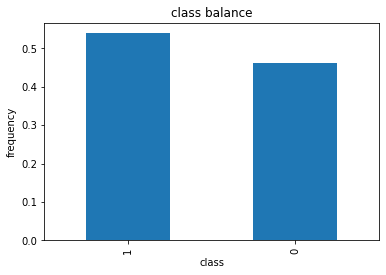

In [11]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar",xlabel="class",ylabel="frequency",title="class balance"
)

**Task 4.5.7:** Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake? Use seaborn to create a boxplot that shows the distributions of the `"plinth_area_sq_ft"` column for both groups in the `"severe_damage"` column. Label your x-axis `"Severe Damage"` and y-axis `"Plinth Area [sq. ft.]"`. Use the title `"Kavrepalanchok, Plinth Area vs Building Damage"`. 

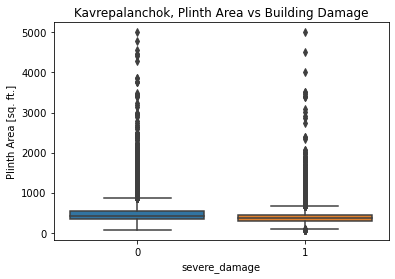

In [12]:
sns.boxplot(x="severe_damage",y="plinth_area_sq_ft",data=df)
# Label axes
plt.xlabel("severe_damage")
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage");

**Task 4.5.8:** Are buildings with certain roof types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"roof_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [13]:
roof_pivot = pd.pivot_table(
    df,index="roof_type",values="severe_damage",aggfunc=np.mean
).sort_values(by="severe_damage")
roof_pivot

,severe_damage
roof_type,
RCC/RB/RBC,0.037574
Bamboo/Timber-Heavy roof,0.570629
Bamboo/Timber-Light roof,0.601164


## Split

**Task 4.5.9:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [14]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (98019, 21)
y shape: (98019,)


**Task 4.5.10:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2 , random_state=42
)

**Task 4.5.10:** Divide your dataset into training and validation sets using a randomized split. Your validation set should be 20% of your data.

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X,y , test_size=0.2 , random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (78415, 21)
y_train shape: (78415,)
X_val shape: (19604, 21)
y_val shape: (19604,)


# Build Model

## Baseline

**Task 4.5.11:** Calculate the baseline accuracy score for your model.

In [17]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.54


## Iterate

**Task 4.5.12:** Create a model `model_lr` that uses logistic regression to predict building damage. Be sure to include an appropriate encoder for categorical features. 

In [23]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
# Fit model to training data
model_lr.fit(X_train,y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

**Task 4.5.13:** Calculate training and validation accuracy score for `model_lr`. 

In [19]:
lr_train_acc = accuracy_score(y_train,model_lr.predict(X_train))
lr_val_acc = model_lr.score(X_val,y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6594274054708921
Logistic Regression, Validation Accuracy Score: 0.6598143236074271


**Task 4.5.14:** Perhaps a decision tree model will perform better than logistic regression, but what's the best hyperparameter value for `max_depth`? Create a `for` loop to train and evaluate the model `model_dt` at all depths from 1 to 15. Be sure to use an appropriate encoder for your model, and to record its training and validation accuracy scores at every depth. The grader will evaluate your validation accuracy scores only.

In [20]:
depth_hyperparams = range(1, 20)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    model_dt.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(model_dt.score(X_train,y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(model_dt.score(X_val,y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.6330676528725372, 0.6349933048523879, 0.6497991455716381]
Validation Accuracy Scores: [0.6348704346051827, 0.6339012446439503, 0.6521118139155274]


**Task 4.5.15:** Using the values in `training_acc` and `validation_acc`, plot the validation curve for `model_dt`. Label your x-axis `"Max Depth"` and your y-axis `"Accuracy Score"`. Use the title `"Validation Curve, Decision Tree Model"`, and include a legend. 

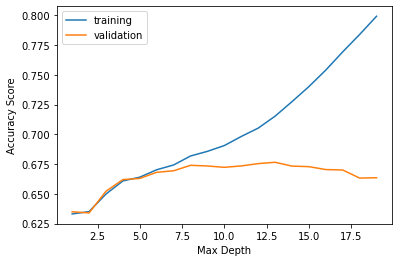

In [21]:
plt.plot(depth_hyperparams,training_acc,label="training")
plt.plot(depth_hyperparams,validation_acc,label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

**Task 4.5.16:** Build and train a new decision tree model `final_model_dt`, using the value for `max_depth` that yielded the best validation accuracy score in your plot above. 

In [22]:
final_model_dt = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=13, random_state=42)
    )
# Fit model to training data
final_model_dt.fit(X_train,y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O'...
                                          'mapping': Not attached       1
Attached-1 side    2
Attached-2 side    3
Attached-3 side    4
NaN               -2
dtype: int64},
                                         {'col': 'plan_configuration',
         

## Evaluate

In [25]:
test_acc = final_model_dt.score(X_test,y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.68


In [26]:
y_test_pred = final_model_dt.predict(X_test)
y_test_pred[:5]

array([1, 1, 1, 1, 1])

# Communicate Results

In [28]:
features = X_train.columns
importances = final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.13031693 0.11738609 0.09965724]


**Task 4.5.18:** What are the most important features for `final_model_dt`? Create a Series Gini `feat_imp`, where the index labels are the feature names for your dataset and the values are the feature importances for your model. Be sure that the Series is sorted from smallest to largest feature importance. 

In [38]:
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.head()

has_superstructure_rc_engineered          0.000518
has_superstructure_rc_non_engineered      0.000730
has_superstructure_other                  0.001143
has_superstructure_cement_mortar_stone    0.001835
has_superstructure_stone_flag             0.002200
dtype: float64

**Task 4.5.19:** Create a horizontal bar chart of `feat_imp`. Label your x-axis `"Gini Importance"` and your y-axis `"Label"`. Use the title `"Kavrepalanchok Decision Tree, Feature Importance"`.

Do you see any relationship between this plot and the exploratory data analysis you did regarding roof type?

Text(0.5, 1.0, 'Kavrepalanchok Decision Tree, Feature Importance')

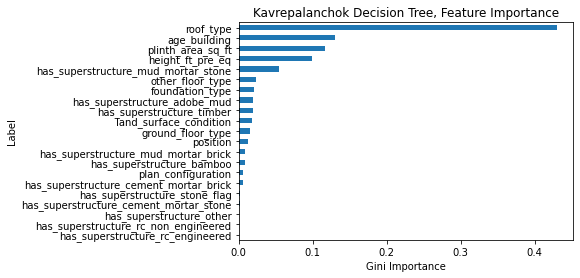

In [36]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Label")
plt.title("Kavrepalanchok Decision Tree, Feature Importance")